In [11]:
#优化 进行后剪枝的决策树

def getData(filename):
    f = open(filename,'r')
    datas = f.readlines()
    label = datas[0].split(',')
    del (label[6])
    # label[len(label)-1] = label[len(label)-1].replace('\n','')
    data_set = []
    for i in range(1,len(datas)):
        temp = datas[i].split(',')
        temp[len(temp) - 1] = temp[len(temp) - 1].replace('\n', '')
        data_set.append(temp)
    return label,data_set

label_set,data_set = getData('Experiment1/data/car_data.csv')

print(label_set)
#加载训练数据 80% 测试数据 20%
train_list = data_set[0:1382]  # 训练集 数据
test_list = data_set[1383:]  # 测试集 数据
print('训练集大小',len(train_list))
print('测试集大小',len(test_list))

label_count = {'buying':4,'maint':4,'doors':4,'persons':3,'lug_boot':3,'safety':3}


# 决策树算法 ID3
import operator
import numpy as np
def classify(tree, label, testVec):  # label为特征的标签值；testVec为测试数据，即所有特征的具体值构成的向量
    firstFeat = ''  # 取出tree的第一个键
    for i in tree.keys():
        firstFeat = i
        break
    secondDict = tree[firstFeat]  # 取出tree第一个键的值，即tree的第二个字典（包含关系）
    labelIndex = label.index(firstFeat)  # 得到第一个特征firstFeat在标签label中的索引
    classLabel = ''
    for key in secondDict.keys():  # 遍历第二个字典的键
        if testVec[labelIndex] == key:  # 如果第一个特征的测试值与第二个字典的键相等时
            if type(secondDict[key]).__name__ == 'dict':  # 如果第二个字典的值还是一个字典，说明分类还没结束，递归执行classify函数
                classLabel = classify(secondDict[key], label, testVec)  # 递归函数中只有输入的第一个参数不同，不断向字典内层渗入
            else:
                classLabel = secondDict[key]  # 最后将得到的分类值赋给classLabel输出
    return classLabel


# 计算信息熵  信息熵即指类别标签的混乱程度，值越小越好 如果一个节点上的数据的类值对于所有数据都相同，
# 则熵最小。 混乱程度越小
def calculateComentropy(dataSet):
    # 训练集大小
    train_list_size = len(dataSet)
    # 类别
    label = {}
    Ent = 0.0
    # 统计每个类别及其数量
    for data in dataSet:
        # 当前样本类型
        classify = data[-1]
        # 如果当前类别不在labelCounts里面，则创建
        if classify not in label.keys():
            label[classify] = 0
        label[classify] += 1
    # 计算香浓熵
    for key in label:
        prob = float(label[key]) / train_list_size
        Ent -= prob * np.log2(prob)
    return Ent


def split_data_set(dataSet, axis, value):
    # 划分数据集, 提取所有满足一个特征的值
    # dataSet: 数据集
    # axis: 划分数据集的特征
    # value: 提取出来满足某特征的list

    result_data_set = []
    for feature in dataSet:
        # 将相同数据特征的提取出来
        if feature[axis] == value:
            reducedFeatVec = []
            for i in range(0, axis):
                reducedFeatVec.append(feature[i])
            for i in range(axis + 1, len(feature)):
                reducedFeatVec.append(feature[i])
            result_data_set.append(reducedFeatVec)
    return result_data_set


# 递归构建决策树  如果数据集已经处理了所有属性，但是类标签依然不是唯一时使用，采用多数表决的方法定义该节点的分类
#特征若已经划分完，节点下的样本还没有统一取值，则需要进行投票
def majority_classify(classList):
    # 类别列表 classList

    # 统计属于每一类的数量
    classCount = {}
    for vote in classList:
        # 如果没出现此类  则创建
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1  # 递增类别标签的值

    # 对字典的value进行排序
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)  # 对各类标签所出现的频率进行降序排序
    # 返回出现次数最多的
    return sortedClassCount[0][0]


# 选择最优的划分属性  即使得信息增益最大的属性    选择信息熵最小的特征，即为最好的分类特征
def choose_best_feature(dataSet):
    # 属性的个数
    feature_num = len(dataSet[0]) - 1  # 计算特征维度时要把类别标签那一列去掉

    # 计算信息熵
    base_entroy = calculateComentropy(dataSet)  # 计算原始数据集的信息熵
    # 信息增益
    bestInfo_Gain = 0.0
    # 得到最大信息增益的特征
    bestFeature = -1
    for i in range(feature_num):
        # 获取第i个特征所有可能的取值
        feature_list = []
        for value in dataSet:
            feature_list.append(value[i])
        # 去除重复值
        unique_feature = set(feature_list)

        # 信息增益
        new_entropy = 0.0
        for value in unique_feature:
            # 切分数据集  去掉 此特征的列
            subDataSet = split_data_set(dataSet, i, value)
            # 特征为i的数据集占总数的比例
            prob = len(subDataSet) / float(len(dataSet))
            # 信息熵
            new_entropy += prob * calculateComentropy(subDataSet)

        # 计算此属性 i 的信息增益
        inforGain = base_entroy - new_entropy

        # 记录得到最大信息增益时  i的值（是那一个属性）
        if inforGain > bestInfo_Gain:
            bestInfo_Gain = inforGain
            bestFeature = i
    return bestFeature


#测试决策树正确率
def testing(myTree,data_test,labels):
    error=0.0
    for i in range(len(data_test)):
        if classify(myTree,labels,data_test[i])!=data_test[i][-1]:
            error+=1
    # print ('myTree %d' %error)
    return float(error)

#测试投票节点正确率
def testingMajor(major,data_test):
    error=0.0
    for i in range(len(data_test)):
        if major!=data_test[i][-1]:
             error+=1
    # print ('major %d' %error)
    return float(error)
import copy
# 构造决策树
def createTree(dataSet, labels,data_test):
    classList = []  # classList是指当前数据集的类别标签
    # 获得类别列表
    for i in dataSet:
        classList.append(i[-1])
    # 当类别与属性完全相同时停止

    if classList.count(classList[0]) == len(classList):  # 计算classList中某个类别标签的数量，若只有一类，则数量与它的数据长度相等
        return classList[0]

    # 遍历完所有特征值时，返回数量最多的  所有的特征值都已经被遍历到
    # 当处理完所有特征而类别标签还不唯一时起作用
    if (len(dataSet[0]) == 1):
        return majority_classify(classList)
    # 获取最佳划分属性 最好的分类特征
    bestFeat = choose_best_feature(dataSet)

    # 接下来使用该分类特征进行分类
    bestFeatLabel = labels[bestFeat]

    myTree = {bestFeatLabel: {}}
    # 清空labels[bestFeat]
    del (labels[bestFeat])

    featValues = []
    for example in dataSet:
        featValues.append(example[bestFeat])
    uniqueVals = set(featValues)

    for value in uniqueVals:
        subLabels = labels[:]
        # 递归调用创建决策树
        myTree[bestFeatLabel][value] = createTree(split_data_set(dataSet, bestFeat, value),
                                                  subLabels,data_test)

    return myTree
import copy
def postPruningTree(inputTree,dataSet,data_test,labels):
    #获得决策树第一层的key值
    firstStr=''
    for i in inputTree.keys():
        firstStr = i
        break
    #获得这个key对应的value
    secondDict=inputTree[firstStr]
    classList = []  # classList是指当前数据集的类别标签
    # 获得类别列表
    for i in dataSet:
        classList.append(i[-1])
    #此特征值
    featkey= copy.deepcopy(firstStr)
    #此特征值在数据中的第几列
    labelIndex=labels.index(featkey)
    #特征的标签
    temp_labels=copy.deepcopy(labels)
    del(labels[labelIndex])
    #递归进行后剪枝
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':
                inputTree[firstStr][key]=postPruningTree(secondDict[key],\
         
               split_data_set(dataSet,labelIndex,key),split_data_set(data_test,labelIndex,key),copy.deepcopy(labels))
   #与预剪枝一样 依旧是判断剪枝前后对分类结果的影响（看分类的错误数的大小）
    if testing(inputTree,data_test,temp_labels)<=testingMajor(majority_classify(classList),data_test):
        return inputTree
    return majority_classify(classList)


#使用pickle模块存储决策树
def storeTree(tree, filename):
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(tree, fw)
    fw.close()





labelTree = label_set[:]  # 在createTree函数中会改变label的值，所以这里先将其赋值给labelTree，防止label的值改变
tree = createTree(train_list, labelTree,test_list)

myTree=postPruningTree(tree,train_list,test_list,label_set)
storeTree(tree, 'Experiment1/data/dataTree_4.txt')
print(myTree)

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
训练集大小 1382
测试集大小 345
{'safety': {'med': {'persons': {'more': {'buying': {'med': {'lug_boot': {'small': {'maint': {'med': 'acc', 'low': {'doors': {'5more': 'acc', '3': 'acc', '2': 'unacc', '4': 'acc'}}, 'vhigh': 'unacc', 'high': 'unacc'}}, 'big': {'maint': {'med': 'acc', 'low': 'good', 'vhigh': 'acc', 'high': 'acc'}}, 'med': {'maint': {'med': 'acc', 'low': {'doors': {'2': 'acc', '5more': 'good', '3': 'good', '4': 'good'}}, 'vhigh': {'doors': {'2': 'unacc', '5more': 'acc', '3': 'acc', '4': 'acc'}}, 'high': {'doors': {'2': 'unacc', '4': 'acc', '3': 'acc', '5more': 'acc'}}}}}}, 'low': {'maint': {'med': {'lug_boot': {'small': 'acc', 'big': 'good', 'med': {'doors': {'4': 'good', '3': 'good', '2': 'acc', '5more': 'good'}}}}, 'low': {'lug_boot': {'med': {'doors': {'4': 'good', '3': 'good', '2': 'acc', '5more': 'good'}}, 'small': 'acc', 'big': 'good'}}, 'vhigh': 'acc', 'high': 'acc'}}, 'vhigh': {'maint': {'med': {'lug_boot': {'med': 

In [13]:

#打开文件取出决策树
def loadTree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

#使用决策树执行分类，返回分类结果

tree = loadTree('Experiment1/data/dataTree_4.txt')
from Experiment1.lolviz import lolviz
g = lolviz.objviz(tree)
g.view() # render and show graphviz.files.Source object

'Source.gv.pdf'

In [12]:
#打开文件取出决策树
def loadTree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)
def classify(tree2, label, testVec):  # label为特征的标签值；testVec为测试数据，即所有特征的具体值构成的向量
    firstFeat = ''  # 取出tree的第一个键
    for i in tree2.keys():
        firstFeat = i
        break
    
    secondDict = tree2[firstFeat]  # 取出tree第一个键的值，即tree的第二个字典（包含关系）
    labelIndex = label.index(firstFeat)  # 得到第一个特征firstFeat在标签label中的索引
    classLabel = ''
    for key in secondDict.keys():  # 遍历第二个字典的键
        if testVec[labelIndex] == key:  # 如果第一个特征的测试值与第二个字典的键相等时
            if type(secondDict[key]).__name__ == 'dict':  # 如果第二个字典的值还是一个字典，说明分类还没结束，递归执行classify函数
                classLabel = classify(secondDict[key], label, testVec)  # 递归函数中只有输入的第一个参数不同，不断向字典内层渗入
            else:
                classLabel = secondDict[key]  # 最后将得到的分类值赋给classLabel输出
    return classLabel

tree = loadTree('Experiment1/data/dataTree_4.txt')
pos_count = 0#正确分类数量
neg_count = 0 #错误分类数量
classify_result_list = [] #存储分类结果
for test in test_list:
    classify_result = classify(tree,label_set,test)
    classify_result_list.append(classify_result)
    
for i in range(0,len(classify_result_list)):
    if classify_result_list[i] == test_list[i][6]:
        pos_count +=1
    else:
        neg_count +=1
print('测试集总数',len(test_list))
print('正确分类数',pos_count)
print('错误分类数',neg_count)
print('分类的准确率为',pos_count/len(test_list))

ValueError: 'safety' is not in list

In [3]:
#对于结果为unacc  classify 为0  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为unacc  即数据集中classify 为0的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为0 且真实为0的数据   将一个正例正确判断为正例
#fp 为预测结果为0 且真实为1，2，3的数据    将一个反例错误判断为正例
#fn 为预测结果为1，2，3 且真实为0的数据     将一个正例错误判断为反例
#tn 为预测结果为1，2，3 且真实为1，2，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == 'unacc' and  classify_result_list[i] == 'unacc':
        tp += 1
    if test_list[i][6] == 'unacc' and  classify_result_list[i] != 'unacc':
        fn += 1
    if test_list[i][6] != 'unacc' and  classify_result_list[i] != 'unacc':
        fp += 1
    if test_list[i][6] != 'unacc' and  classify_result_list[i] != 'unacc':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值 
f1 = (2*precision*recall) / (precision+recall)
print('f1值 ————',f1)


            
            
       


对于结果为unacc  即数据集中classify 为0的   构建混淆矩阵 计算准确率 精度 召回率 F 度量


ZeroDivisionError: division by zero

对于结果为acc  即数据集中classify 为1的   构建混淆矩阵 计算准确率 精度 召回率 F 度量


ZeroDivisionError: division by zero

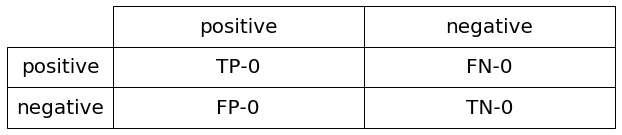

In [5]:
#对于结果为acc  classify 为1  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为acc  即数据集中classify 为1的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为1 且真实为1的数据   将一个正例正确判断为正例
#fp 为预测结果为1 且真实为0，2，3的数据    将一个反例错误判断为正例
#fn 为预测结果为0，2，3 且真实为1的数据     将一个正例错误判断为反例
#tn 为预测结果为0，2，3 且真实为0，2，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == 'unacc' and  classify_result_list[i] == 'unacc':
        tp += 1
    if test_list[i][6] == 'unacc' and  classify_result_list[i] != 'unacc':
        fn += 1
    if test_list[i][6] != 'unacc' and  classify_result_list[i] != 'unacc':
        fp += 1
    if test_list[i][6] != 'unacc' and  classify_result_list[i] != 'unacc':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值 
f1 = (2*precision*recall) / (precision+recall)
print('f1值 ————',f1)

对于结果为good  即数据集中classify 为2的   构建混淆矩阵 计算准确率 精度 召回率 F 度量
准确率———— 0.48955223880597015
精度(查准率) ———— 0.006097560975609756
召回率(查全率)———— 0.48955223880597015
f1值 ———— 0.011560693641618497


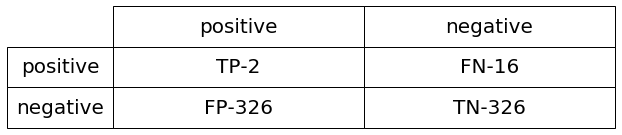

In [7]:
#对于结果为good  classify 为2  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为good  即数据集中classify 为2的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为2 且真实为2的数据   将一个正例正确判断为正例
#fp 为预测结果为2 且真实为0，1，3的数据    将一个反例错误判断为正例
#fn 为预测结果为0，1，3 且真实为2的数据     将一个正例错误判断为反例
#tn 为预测结果为0，1，3 且真实为0，1，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == '2' and  classify_result_list[i] == '2':
        tp += 1
    if test_list[i][6] == '2' and  classify_result_list[i] != '2':
        fn += 1
    if test_list[i][6] != '2' and  classify_result_list[i] != '2':
        fp += 1
    if test_list[i][6] != '2' and  classify_result_list[i] != '2':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值 
if 2*precision*recall == 0:
    print('f1值 ————',0.0)
else:
    f1 = (2*precision*recall) / (precision+recall)
    print('f1值 ————',f1)

对于结果为vgood  即数据集中classify 为3的   构建混淆矩阵 计算准确率 精度 召回率 F 度量
准确率———— 0.4911242603550296
精度(查准率) ———— 0.0030120481927710845
召回率(查全率)———— 0.4911242603550296
f1值 ———— 0.005780346820809249


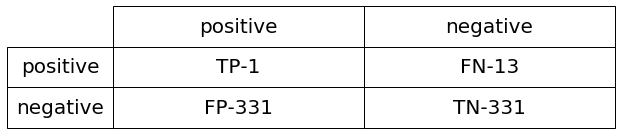

In [8]:
#对于结果为vgood  classify 为3  构建混淆矩阵 计算准确率 精度 召回率 F 度量
print('对于结果为vgood  即数据集中classify 为3的   构建混淆矩阵 计算准确率 精度 召回率 F 度量')
tp, fp, fn, tn = 0, 0, 0, 0
#tp 为预测结果为2 且真实为2的数据   将一个正例正确判断为正例
#fp 为预测结果为2 且真实为0，1，3的数据    将一个反例错误判断为正例
#fn 为预测结果为0，1，3 且真实为2的数据     将一个正例错误判断为反例
#tn 为预测结果为0，1，3 且真实为0，1，3的数据   将一个反例正确判断为反例
for i in range(0,len(classify_result_list)):
    if test_list[i][6] == '3' and  classify_result_list[i] == '3':
        tp += 1
    if test_list[i][6] == '3' and  classify_result_list[i] != '3':
        fn += 1
    if test_list[i][6] != '3' and  classify_result_list[i] != '3':
        fp += 1
    if test_list[i][6] != '3' and  classify_result_list[i] != '3':
        tn += 1
            
            
#混淆矩阵
from matplotlib import pyplot as plt
col_labels = ['positive','negative']

row_labels = ['positive','negative']
R, C = len(row_labels), len(col_labels)
figC, figR = 2.25*C, R
fig = plt.figure(figsize=(figC, figR))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

table_vals = [['TP-'+str(tp),'FN-'+str(fn)],['FP-'+str(fp),'TN-'+str(tn)]]
my_table = plt.table(cellText=table_vals, rowLabels=row_labels, 
                     colLabels=col_labels, 
                     rowLoc='center', loc='center',cellLoc='center')
my_table.set_fontsize(20)
    
    # 伸缩表格大小常数
my_table.scale(figR/R*2 ,figC/C*1.5)
#准确率   分类正确的样本数占样本总数的比例
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('准确率————',accuracy)

#精度   预测为正例的样本中真正为正例的比例：
precision = (tp) / (tp+fp)
print('精度(查准率) ————',precision)
#召回率  真正为正例的样本中正确预测为正例的比例：
recall = (tp) / (tp+fn)
print('召回率(查全率)————',accuracy)
#f值
if 2*precision*recall == 0:
    print('f1值 ————',0.0)
else:
    f1 = (2*precision*recall) / (precision+recall)
    print('f1值 ————',f1)